## Setup

In [126]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_utils
import brain_observatory_utilities.datasets.electrophysiology.utilities as ephys_utils

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

import matplotlib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic functions for jupyter notebook plotting
%matplotlib inline

In [127]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [128]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

In [129]:
# get the metadata tables
units_table = cache.get_unit_table()

channels_table = cache.get_channel_table()

probes_table = cache.get_probe_table()

behavior_sessions_table = cache.get_behavior_session_table()

ecephys_sessions_table = cache.get_ecephys_session_table()

In [130]:
# file paths
recording_type = 'ephys'
postproc_dir = '/root/capsule/postprocessed/'+recording_type+'/'
fig_dir = '/root/capsule/figures/'+recording_type+'/'

## Load data

In [131]:
session_id = 1048196054
session = cache.get_ecephys_session(ecephys_session_id=session_id)

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [250]:
# load neural data
spike_times = session.spike_times

# load behavioral data
all_stim_pres = session.stimulus_presentations
stim_pres = behavior_utils.get_annotated_stimulus_presentations(session) # only image presentations in stim block 0 - why?

/opt/conda/lib/python3.10/site-packages/brain_observatory_utilities/datasets/behavior/data_formatting.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['change_trials_id'] = trials.index.values


In [251]:
# get unit and channel data, sort the units by depth and filter for "good" units
units = session.get_units() # contains information about spike waveforms, isolation quality
channels = session.get_channels() # contains information about anatomical location

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True) # associate anatomical information with each unit

# sort units by depth
unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

# filter units using QC metrics
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<.5)&
                    (unit_channels['firing_rate']>0.1)&
                    (unit_channels['amplitude_cutoff']<0.1)&
                    (unit_channels['presence_ratio']>.9)
                   )

good_units = unit_channels.loc[good_unit_filter]

# filter by brain region
area_of_interest = 'VIS'
area_units = good_units[good_units['structure_acronym'].str.contains(area_of_interest)]
# area_units = good_units[good_units['structure_acronym'] == area_of_interest]
num_units = len(area_units)
print(num_units)

275


## PCA on entire block - time across session x unit

In [252]:
# get binned spike rates
bin_size = 0.04 # seconds
spike_rate_df, timestamps = ephys_utils.get_continous_spike_rate_for_units(session, spike_rate_bin_size=bin_size, stimulus_block=0)

(90188, 275)
(90188, 275)


PCA(n_components=275)

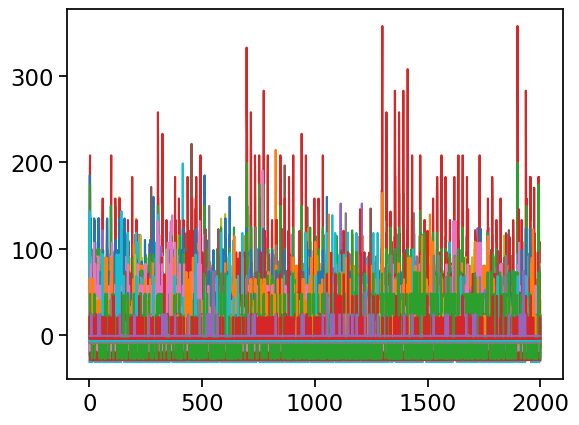

In [253]:
# create matrix of samples x features
area_units_spike_rate_df = spike_rate_df.loc[area_units.index]
binned_spikes = np.array([area_units_spike_rate_df.iloc[i].values[0] for i in range(num_units)]).T
print(binned_spikes.shape)

# de-mean data
X = binned_spikes - binned_spikes.mean(axis=0)
print(X.shape)

plt.plot(X[:2000,])

# perform PCA
pca = PCA(n_components=num_units)
pca.fit(X)

0.35390312215878916


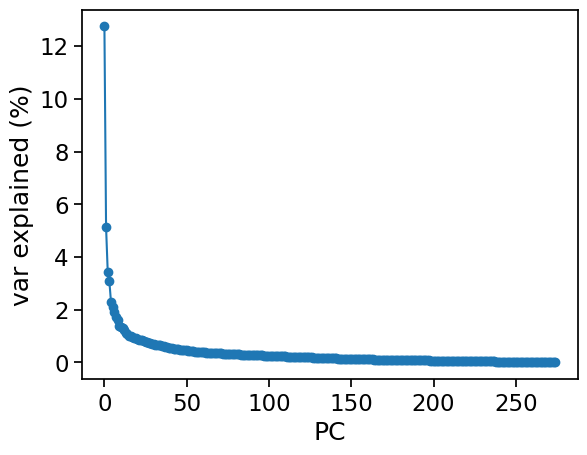

In [254]:
# visualize variance explained by PCs
plt.plot(pca.explained_variance_ratio_*100, 'o-')
plt.xlabel('PC')
plt.ylabel('var explained (%)')

# variance explained by top PCs
latent_dim = 10
latent_space = pca.components_[:latent_dim]
print(pca.explained_variance_ratio_[:latent_dim].sum())

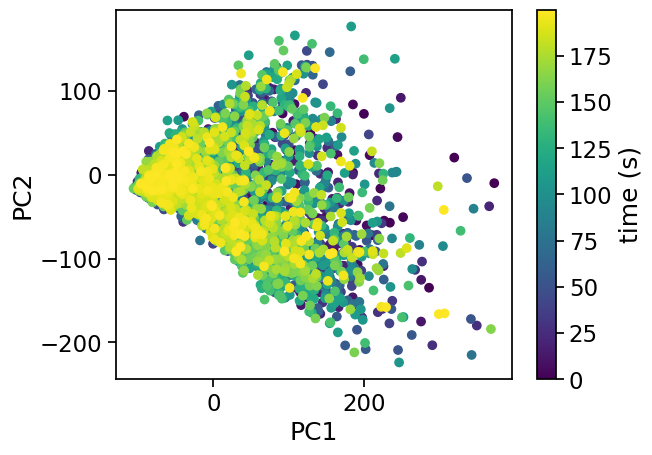

In [255]:
# project data onto top PCs
binned_spikes_proj = pca.fit_transform(X) # samples x components

t = 5000
plt.scatter(binned_spikes_proj[:t,0], binned_spikes_proj[:t,1], c=timestamps[:t])
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('time (s)')

## PCA on time window around image change - time within trial x unit

In [256]:
# helper functions for binning spike counts into rates
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/startTimes.size
    return counts/binSize, bins

def makePSTH_wrapper(area_units, spike_times, all_event_times, event_idx_to_use, time_before, time_after, bin_size=0.04):
    event_responses = []
    event_times = all_event_times[event_idx_to_use]
    
    for iu, unit in area_units.iterrows():
        unit_response, bins = makePSTH(spike_times[iu], event_times-time_before, time_before+time_after, bin_size)
        event_responses.append(unit_response)
        
    return np.array(event_responses), bins

subdivide all trials where is_change True:

F-F: previous trial's is_image_novel False, is_image_novel False

F-N: previous trial's is_image_novel False, is_image_novel True

N-F: previous trial's is_image_novel True, is_image_novel False

N-N: previous trial's is_image_novel True, is_image_novel True

In [257]:
# create df with all image change trials 
change_trial_df = stim_pres[stim_pres['is_change']]
preceding_trial_idx = change_trial_df.index-1 # index is stimulus_presentations_id

# before & after image are both novel 
nn_idx = np.where(stim_pres.loc[preceding_trial_idx]['is_image_novel'].values & change_trial_df['is_image_novel'].values)[0]

# before & after image are both familiar
ff_idx = np.where(~stim_pres.loc[preceding_trial_idx]['is_image_novel'].values & ~change_trial_df['is_image_novel'].values)[0]

# before image is novel, after image is familiar
nf_idx = np.where(stim_pres.loc[preceding_trial_idx]['is_image_novel'].values & ~change_trial_df['is_image_novel'].values)[0]

# before image is familiar, after image is novel
fn_idx = np.where(~stim_pres.loc[preceding_trial_idx]['is_image_novel'].values & change_trial_df['is_image_novel'].values)[0]

print(len(nn_idx), len(ff_idx), len(nf_idx), len(fn_idx))

151 11 62 62


In [258]:
# align data to image change, for each condition
spike_times = session.spike_times
all_event_times = change_trial_df.start_time.values
time_before = 1
time_after = .75
bin_size = 0.04

# get trial-averaged response per unit to each image change condition
nn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, nn_idx, time_before, time_after, bin_size=bin_size)
ff_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, ff_idx, time_before, time_after, bin_size=bin_size)
nf_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, nf_idx, time_before, time_after, bin_size=bin_size)
fn_responses, bins = makePSTH_wrapper(area_units, spike_times, all_event_times, fn_idx, time_before, time_after, bin_size=bin_size)

### Response by condition

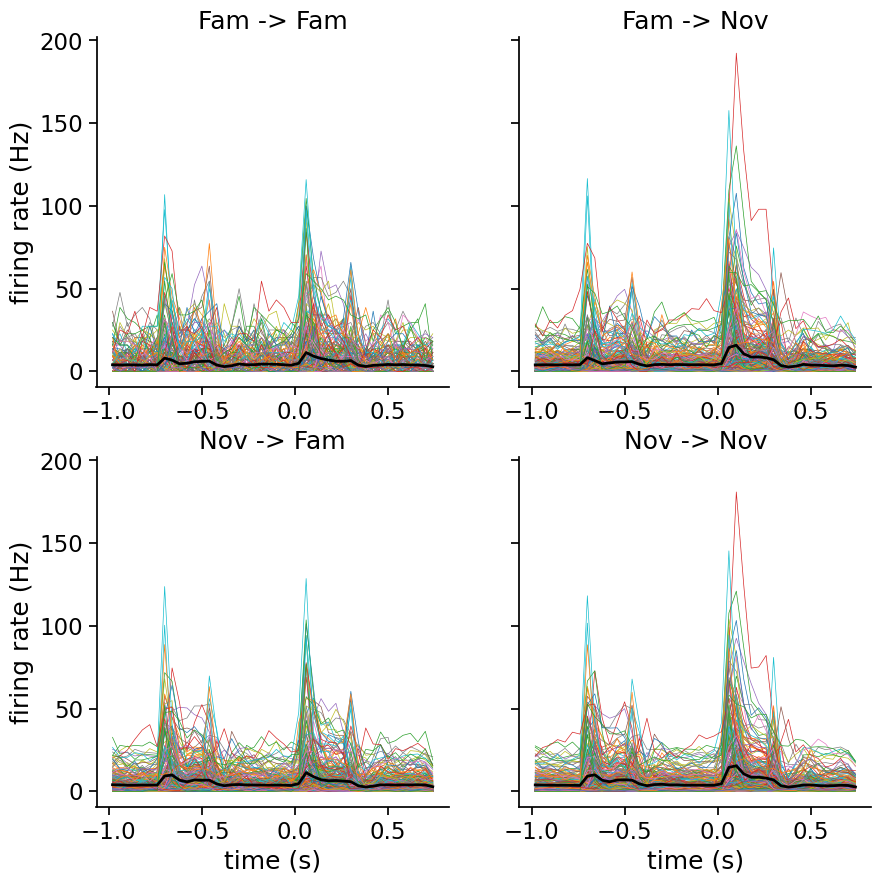

In [259]:
# plot trial-averaged unit responses to each image change condition
w = .5
fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=True)
for i in range(2):
    for j in range(2):
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        
time_bins = np.arange(-time_before, time_after, bin_size)+bin_size/2

ax[0,0].set_title('Fam -> Fam')
ax[0,0].plot(time_bins, ff_responses.T, linewidth=w)
ax[0,0].plot(time_bins, ff_responses.mean(axis=0), 'k', linewidth=2)
ax[0,0].set_ylabel('firing rate (Hz)')

ax[0,1].set_title('Fam -> Nov')
ax[0,1].plot(time_bins, fn_responses.T, linewidth=w)
ax[0,1].plot(time_bins, fn_responses.mean(axis=0), 'k', linewidth=2)

ax[1,0].set_title('Nov -> Fam')
ax[1,0].plot(time_bins, nf_responses.T, linewidth=w)
ax[1,0].plot(time_bins, nf_responses.mean(axis=0), 'k', linewidth=2)
ax[1,0].set_xlabel('time (s)')
ax[1,0].set_ylabel('firing rate (Hz)')

ax[1,1].set_title('Nov -> Nov')
ax[1,1].plot(time_bins, nn_responses.T, linewidth=w)
ax[1,1].plot(time_bins, nn_responses.mean(axis=0), 'k', linewidth=2)
ax[1,1].set_xlabel('time (s)');

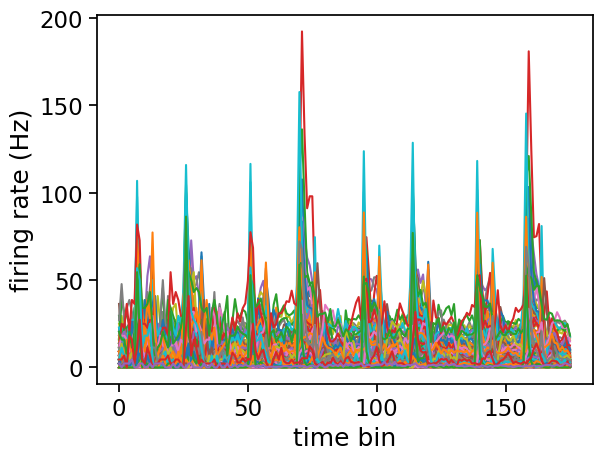

In [260]:
# concatenate image change conditions together
concat_responses = np.hstack([ff_responses,fn_responses,nf_responses,nn_responses])
timestamps = np.arange(concat_responses.shape[1])
plt.plot(concat_responses.T)
plt.xlabel('time bin')
plt.ylabel('firing rate (Hz)');

### PCA

(176, 275)


PCA(n_components=176)

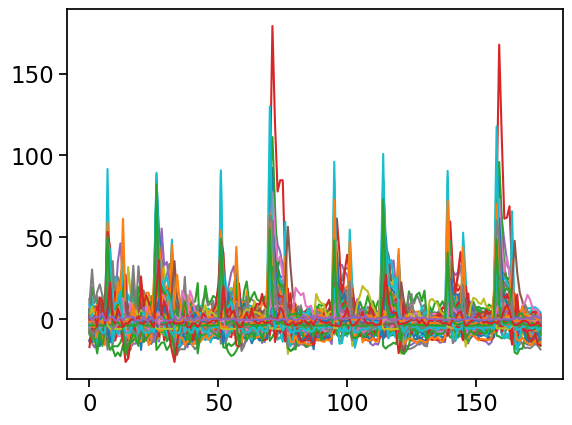

In [261]:
# create de-meaned matrix of samples x features
X = concat_responses.T - concat_responses.T.mean(axis=0)
print(X.shape)

# plot data (each unit is a different color)
plt.plot(X[:2000,]);

# perform PCA
pca = PCA(n_components=min(num_units,X.shape[0]))
pca.fit(X)

0.8971697131866313


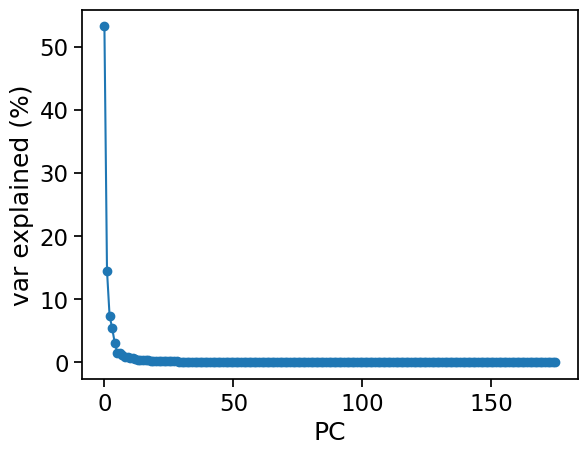

In [262]:
# visualize variance explained by PCs
plt.plot(pca.explained_variance_ratio_*100, 'o-')
plt.xlabel('PC')
plt.ylabel('var explained (%)')

# variance explained by top PCs
latent_dim = 10
latent_space = pca.components_[:latent_dim]
print(pca.explained_variance_ratio_[:latent_dim].sum())

### Projection

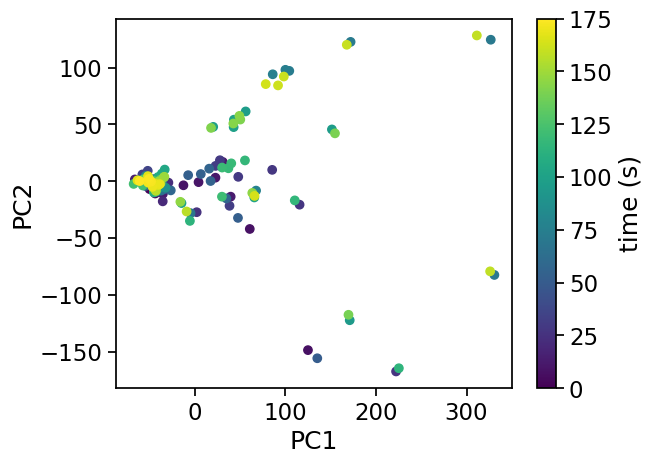

In [263]:
# project data onto top PCs
concat_responses_proj = pca.fit_transform(X) # samples x components

t = len(timestamps)
plt.scatter(concat_responses_proj[:t,0], concat_responses_proj[:t,1], c=timestamps[:t])
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('time (s)')

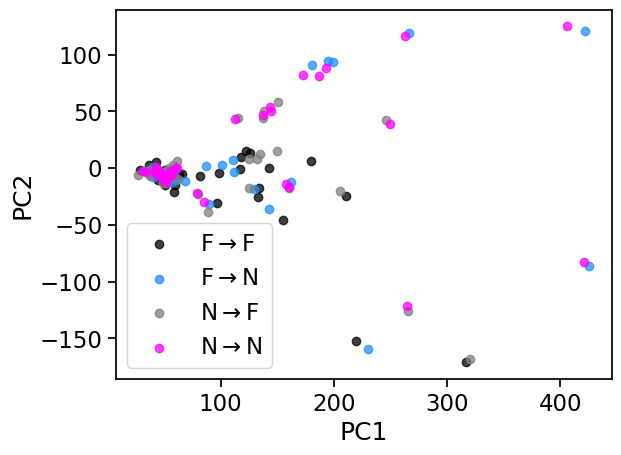

In [264]:
# project responses to each condition onto top PCs
ff_responses_proj = pca.transform(ff_responses.T) # input should be samples x features
fn_responses_proj = pca.transform(fn_responses.T)
nf_responses_proj = pca.transform(nf_responses.T)
nn_responses_proj = pca.transform(nn_responses.T)

a = .75
pc_idx_x = 0
pc_idx_y = 1
plt.scatter(ff_responses_proj[:,pc_idx_x], ff_responses_proj[:,pc_idx_y], c='black', alpha=a, label=r'F$\rightarrow$F')
plt.scatter(fn_responses_proj[:,pc_idx_x], fn_responses_proj[:,pc_idx_y], c='dodgerblue', alpha=a, label=r'F$\rightarrow$N')
plt.scatter(nf_responses_proj[:,pc_idx_x], nf_responses_proj[:,pc_idx_y], c='gray', alpha=a, label=r'N$\rightarrow$F')
plt.scatter(nn_responses_proj[:,pc_idx_x], nn_responses_proj[:,pc_idx_y], c='fuchsia', alpha=a, label=r'N$\rightarrow$N')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend();

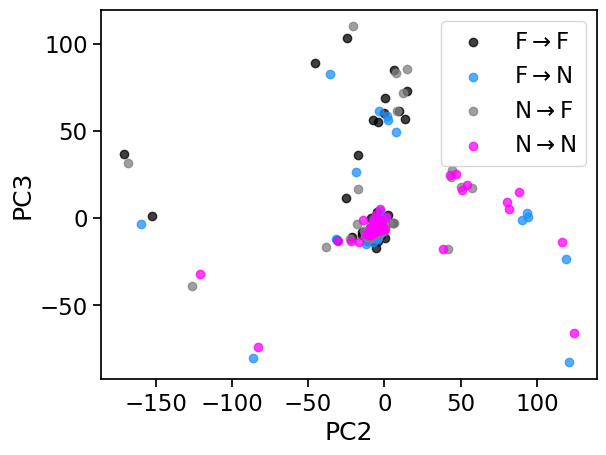

In [265]:
# project responses to each condition onto top PCs
a = .75
t = len(bins)
pc_idx_x = 1
pc_idx_y = 2
plt.scatter(ff_responses_proj[:,pc_idx_x], ff_responses_proj[:,pc_idx_y], c='black', alpha=a, label=r'F$\rightarrow$F')
plt.scatter(fn_responses_proj[:,pc_idx_x], fn_responses_proj[:,pc_idx_y], c='dodgerblue', alpha=a, label=r'F$\rightarrow$N')
plt.scatter(nf_responses_proj[:,pc_idx_x], nf_responses_proj[:,pc_idx_y], c='gray', alpha=a, label=r'N$\rightarrow$F')
plt.scatter(nn_responses_proj[:,pc_idx_x], nn_responses_proj[:,pc_idx_y], c='fuchsia', alpha=a, label=r'N$\rightarrow$N')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend();

### Projection animation 2d

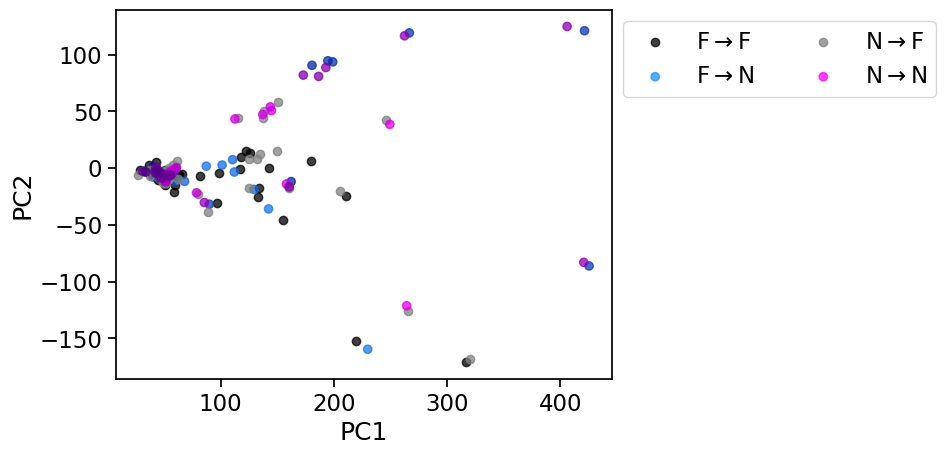

In [300]:
# project responses to each condition onto top PCs
a = .75
pc_idx_x = 0
pc_idx_y = 1
fig, ax = plt.subplots(1,1)

fn_norm = plt.Normalize(0,len(fn_responses_proj))
fn_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["dodgerblue","navy"])
nn_norm = plt.Normalize(0,len(nn_responses_proj))
nn_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["fuchsia","indigo"])

ax.scatter(ff_responses_proj[:,pc_idx_x], ff_responses_proj[:,pc_idx_y], c='black', alpha=a, label=r'F$\rightarrow$F')
ax.scatter(fn_responses_proj[:,pc_idx_x], fn_responses_proj[:,pc_idx_y], c=range(len(fn_responses_proj)), cmap=fn_cmap, norm=fn_norm, alpha=a, label=r'F$\rightarrow$N')
ax.scatter(nf_responses_proj[:,pc_idx_x], nf_responses_proj[:,pc_idx_y], c='gray', alpha=a, label=r'N$\rightarrow$F')
ax.scatter(nn_responses_proj[:,pc_idx_x], nn_responses_proj[:,pc_idx_y], c=range(len(nn_responses_proj)), cmap=nn_cmap, norm=nn_norm, alpha=a, label=r'N$\rightarrow$N')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(ncol=2, bbox_to_anchor=(1,1), loc='upper left');

xlim = ax.get_xlim(); ylim = ax.get_ylim()

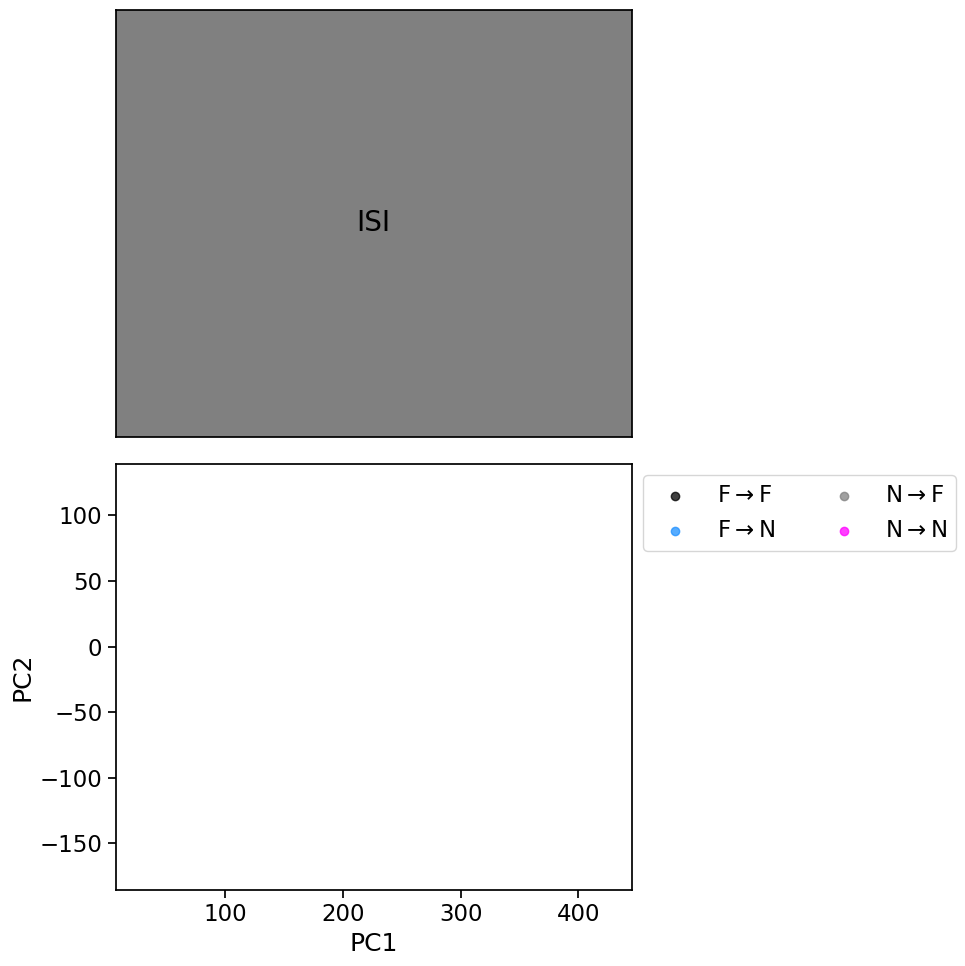

In [267]:
import matplotlib.animation as animation
import matplotlib.patches as patches

fig, ax = plt.subplots(2,1, figsize=(10,10))

# create flash for image change
prev_on_idx = np.searchsorted(time_bins, -0.75)
prev_off_idx = np.searchsorted(time_bins[prev_on_idx:], -0.5)
on_idx = np.searchsorted(time_bins[prev_on_idx+prev_off_idx:], 0)
off_idx = np.searchsorted(time_bins[prev_on_idx+prev_off_idx+on_idx:], 0.25)
end_idx = len(time_bins[prev_on_idx+prev_off_idx+on_idx+off_idx:])
patch_color = np.concatenate((
    np.repeat('gray', 1), # init frame
    np.repeat('gray', prev_on_idx), # gray screen
    np.repeat('limegreen', prev_off_idx), # image on
    np.repeat('gray', on_idx), # gray screen
    np.repeat('limegreen', off_idx), # image on
    np.repeat('gray', end_idx) # gray screen
))

# create labels for image change
labels = np.concatenate((
    np.repeat('ISI', 1), # init frame
    np.repeat('ISI', prev_on_idx), # gray screen
    np.repeat('IMAGE ON', prev_off_idx), # image on
    np.repeat('ISI', on_idx), # gray screen
    np.repeat('IMAGE ON', off_idx), # image on
    np.repeat('ISI', end_idx) # gray screen
))
time_labels = [''] + ['t= '+str(np.round(i,2))+'s' for i in time_bins]

# scatter plots
ff_scat = ax[1].scatter(ff_responses_proj[0,pc_idx_x], ff_responses_proj[0,pc_idx_y], c='black', alpha=a, label=r'F$\rightarrow$F')
fn_scat = ax[1].scatter(fn_responses_proj[0,pc_idx_x], fn_responses_proj[0,pc_idx_y], c='dodgerblue', alpha=a, label=r'F$\rightarrow$N')
nf_scat = ax[1].scatter(nf_responses_proj[0,pc_idx_x], nf_responses_proj[0,pc_idx_y], c='gray', alpha=a, label=r'N$\rightarrow$F')
nn_scat = ax[1].scatter(nn_responses_proj[0,pc_idx_x], nn_responses_proj[0,pc_idx_y], c='fuchsia', alpha=a, label=r'N$\rightarrow$N')

# line plots
ff_line = ax[1].plot(ff_responses_proj[0,pc_idx_x], ff_responses_proj[0,pc_idx_y], c='black', alpha=a)[0]
fn_line = ax[1].plot(fn_responses_proj[0,pc_idx_x], fn_responses_proj[0,pc_idx_y], c='dodgerblue', alpha=a)[0]
nf_line = ax[1].plot(nf_responses_proj[0,pc_idx_x], nf_responses_proj[0,pc_idx_y], c='gray', alpha=a)[0]
nn_line = ax[1].plot(nn_responses_proj[0,pc_idx_x], nn_responses_proj[0,pc_idx_y], c='fuchsia', alpha=a)[0]

# rectangle
patch = patches.Rectangle((0, 0), 1, 1, facecolor=patch_color[0], fill=True)
ax[0].add_patch(patch)

# text
txt = ax[0].text(.5, .5, '', fontsize=20, verticalalignment='center', horizontalalignment='center')
time_txt = ax[0].text(.5, .4, '', fontsize=16, verticalalignment='center', horizontalalignment='center')

ax[1].set(xlim=xlim, ylim=ylim, xlabel='PC1', ylabel='PC2')
leg = ax[1].legend(ncols=2, bbox_to_anchor=(1,1), loc='upper left')
ax[0].set(xlim=(0,1), ylim=(0,1), xlabel='', ylabel='', xticks=[], yticks=[])

def update(frame):
    # update scatter plots
    ff_scat.set_offsets( np.stack([ff_responses_proj[:frame,pc_idx_x], ff_responses_proj[:frame,pc_idx_y]]).T )
    fn_scat.set_offsets( np.stack([fn_responses_proj[:frame,pc_idx_x], fn_responses_proj[:frame,pc_idx_y]]).T )
    nf_scat.set_offsets( np.stack([nf_responses_proj[:frame,pc_idx_x], nf_responses_proj[:frame,pc_idx_y]]).T )
    nn_scat.set_offsets( np.stack([nn_responses_proj[:frame,pc_idx_x], nn_responses_proj[:frame,pc_idx_y]]).T )
    
    # update line plots
    ff_line.set_xdata(ff_responses_proj[:frame,pc_idx_x])
    ff_line.set_ydata(ff_responses_proj[:frame,pc_idx_y])
    fn_line.set_xdata(fn_responses_proj[:frame,pc_idx_x])
    fn_line.set_ydata(fn_responses_proj[:frame,pc_idx_y])
    nf_line.set_xdata(nf_responses_proj[:frame,pc_idx_x])
    nf_line.set_ydata(nf_responses_proj[:frame,pc_idx_y])
    nn_line.set_xdata(nn_responses_proj[:frame,pc_idx_x])
    nn_line.set_ydata(nn_responses_proj[:frame,pc_idx_y])
    
    # update rectangle
    patch.set_facecolor(patch_color[frame])
    
    # update text
    txt.set_text(labels[frame])
    time_txt.set_text(time_labels[frame])
    
    # # keep legend consistent
    leg.set_ncols(2)
    leg.set_bbox_to_anchor((1,1))
    leg.set_loc('upper left')

    return (ff_scat, fn_scat, nf_scat, nn_scat, ff_line, fn_line, nf_line, nn_line, patch, txt, time_txt, leg)

n_frames = len(time_bins)+1
isi = 750 # in ms
ani = animation.FuncAnimation(fig=fig, func=update, frames=n_frames, interval=isi)
plt.tight_layout()

filename = f"pca_trialavg_proj_{session_id}_{area_of_interest}"
ani.save(fig_dir+filename+'.gif', writer="pillow")

### Projection animation 3d

### Top 3 PCs

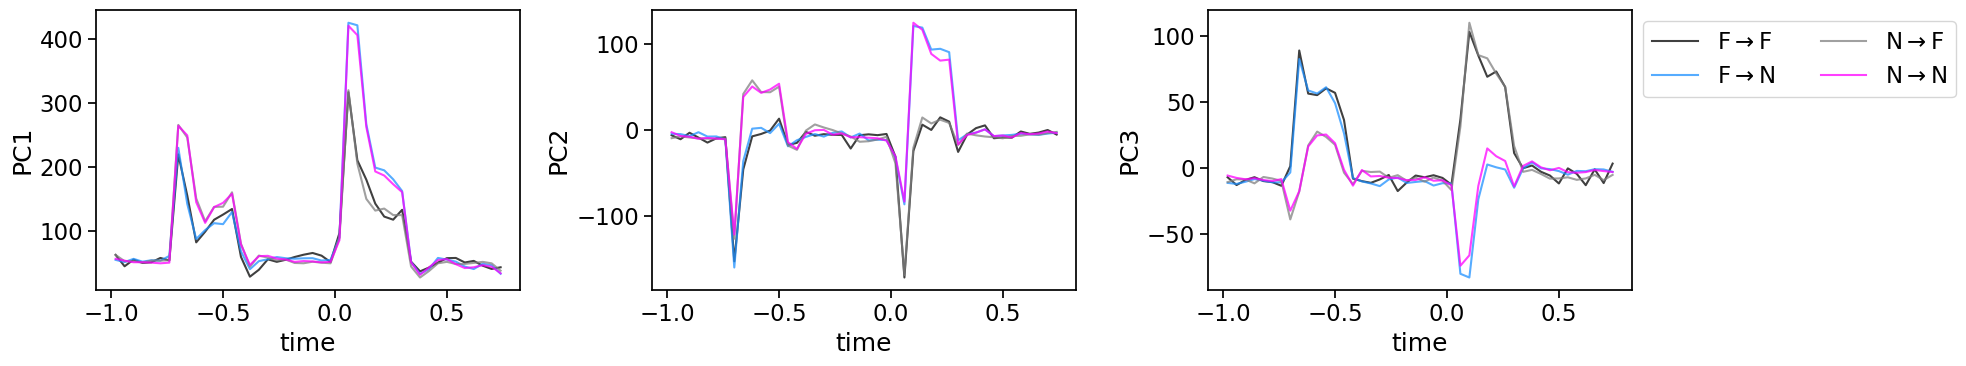

In [301]:
# plot projection onto top PCs vs. time within trial
fig, ax = plt.subplots(1,3, figsize=(20,4))
a = .75

for i in range(3):
    pc_idx = i
    ax[i].plot(time_bins, ff_responses_proj[:,pc_idx], c='black', alpha=a, label=r'F$\rightarrow$F')
    ax[i].plot(time_bins, fn_responses_proj[:,pc_idx], c='dodgerblue', alpha=a, label=r'F$\rightarrow$N')
    ax[i].plot(time_bins, nf_responses_proj[:,pc_idx], c='gray', alpha=a, label=r'N$\rightarrow$F')
    ax[i].plot(time_bins, nn_responses_proj[:,pc_idx], c='fuchsia', alpha=a, label=r'N$\rightarrow$N')
    ax[i].set_xlabel('time')
    ax[i].set_ylabel(f'PC{i+1}')
ax[i].legend(ncol=2, bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout();

### Heatmap of PCs

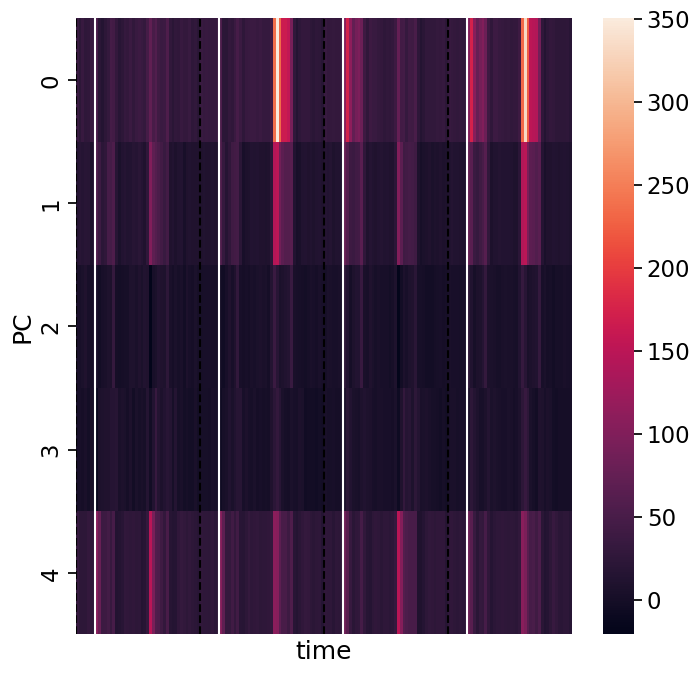

In [297]:
# heatmap of projection onto PCs vs. time (components x concatenated times)
plt.figure(figsize=(8,8))
pcs = pca.components_
sns.heatmap((pcs @ concat_responses)[:5,:])
plt.xticks([])
plt.xlabel('time')
plt.ylabel('PC')

# add lines to separate conditions
for i in range(4):
    plt.axvline(x=(t-1)*i, color='k', linestyle='--')

# add lines for image change onset 
for i in range(4):
    plt.axvline(x=7+(t-1)*i, color='w', linestyle='-') # don't hardcode
    
# label conditions
# ff_responses,fn_responses,nf_responses,nn_responses

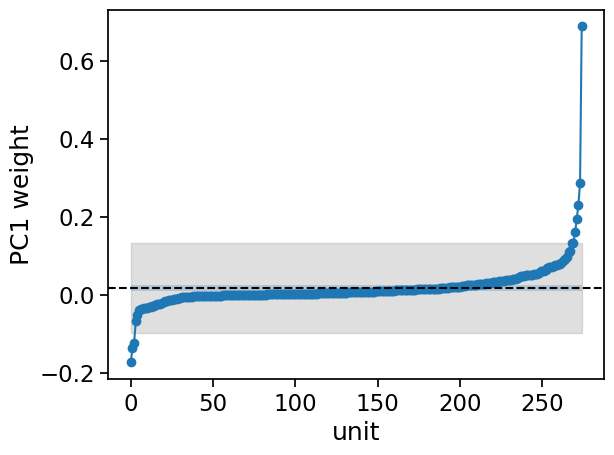

In [299]:
# plot component weights for each unit (check that there's not just a few super active units that bias the PCA)
sorted_pc = np.sort(pcs[0,:])
plt.plot(sorted_pc, 'o-')
plt.xlabel('unit')
plt.ylabel('PC1 weight')

# add CI thresholds to see which units fall outside this ( 95% CI = mu +/- 1.96*SEM = 1.96*SD/sqrt(N) )
z = 2
plt.axhline(sorted_pc.mean(), color='k', linestyle='--')
plt.fill_between(range(num_units), sorted_pc.mean() - z*sorted_pc.std()/np.sqrt(num_units), sorted_pc.mean() + z*sorted_pc.std()/np.sqrt(num_units), alpha=.25)

# add SD thresholds (95% of data falls within 2 SDs from mean)
plt.fill_between(range(num_units), sorted_pc.mean() - 2*sorted_pc.std(), sorted_pc.mean() + 2*sorted_pc.std(), color='gray', alpha=.25);

## PCA on time window around image change - trial x unit

In [271]:
def get_spike_trains(spikes, startTimes, windowDur, binSize=0.01):
    bins = np.arange(0,windowDur+binSize,binSize)
    trains = np.zeros((len(startTimes), bins.size-1))
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        trains[i] = np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    return trains, bins

def get_spike_trains_wrapper(area_units, spike_times, all_event_times, event_idx_to_use, time_before, time_after, bin_size=0.01):
    '''
     From spike times, create a spike train, i.e. a sequence of zeros and ones, where time is discretized in 1 ms steps.
     A zero indicates that the neuron did not spike in the 1 ms bin, whereas a one indicates that the neuron spiked once in the 1 ms bin.
    Returns:
        spike_trains (nchan, ntrial, ntime)
        bins
    '''
    spike_trains = []
    event_times = all_event_times[event_idx_to_use]
    
    for iu, unit in area_units.iterrows():
        trains, bins = get_spike_trains(spike_times[iu], event_times-time_before, time_before+time_after, bin_size)
        spike_trains.append(trains)
        
    return np.array(spike_trains), bins

In [272]:
# align data to image change, for each condition
spike_times = session.spike_times
all_event_times = change_trial_df.start_time.values
time_before = 0
time_after = .25
bin_size = 0.01

# get spike trains from spike times (units x trials x time bins for each image condition)
nn_trains, bins = get_spike_trains_wrapper(area_units, spike_times, all_event_times, nn_idx, time_before, time_after, bin_size=bin_size)
ff_trains, bins = get_spike_trains_wrapper(area_units, spike_times, all_event_times, ff_idx, time_before, time_after, bin_size=bin_size)
nf_trains, bins = get_spike_trains_wrapper(area_units, spike_times, all_event_times, nf_idx, time_before, time_after, bin_size=bin_size)
fn_trains, bins = get_spike_trains_wrapper(area_units, spike_times, all_event_times, fn_idx, time_before, time_after, bin_size=bin_size)

# get total spike count in time window
nn_counts = nn_trains.sum(axis=2) # sum over time bins
ff_counts = ff_trains.sum(axis=2)
nf_counts = nf_trains.sum(axis=2)
fn_counts = fn_trains.sum(axis=2)

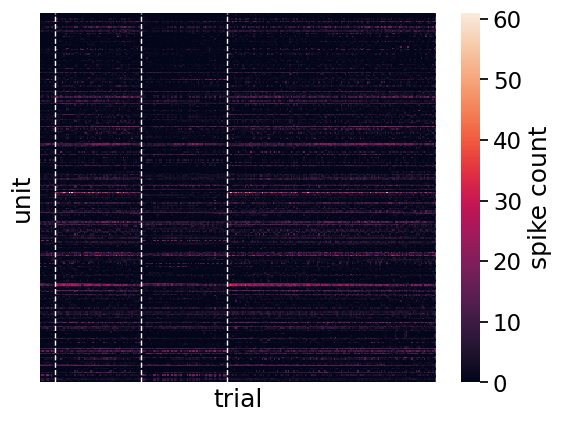

In [273]:
# concatenate image change conditions together
concat_counts = np.hstack([ff_counts,fn_counts,nf_counts,nn_counts])
sns.heatmap(concat_counts, cbar_kws={'label':'spike count'})
plt.xticks([])
plt.yticks([])
plt.xlabel('trial')
plt.ylabel('unit')

# add lines to separate conditions
cum_ntr = 0
for ntr in [len(ff_idx), len(fn_idx), len(nf_idx), len(nn_idx)]:
    cum_ntr += ntr
    plt.axvline(x=cum_ntr, color='w', linestyle='--', linewidth=1)

(286, 275)


PCA(n_components=275)

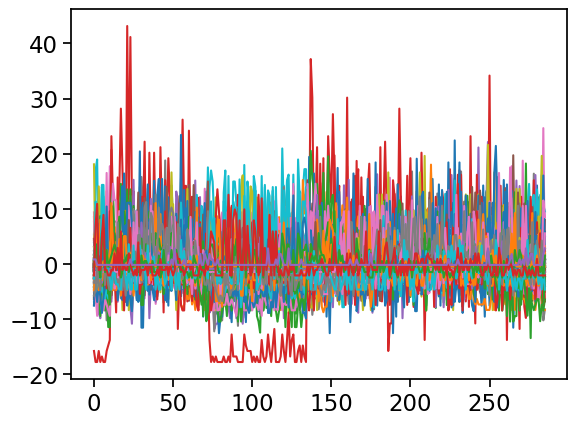

In [274]:
# create de-meaned matrix of samples x features
X = concat_counts.T - concat_counts.T.mean(axis=0)
print(X.shape)

# plot data (each unit is a different color)
plt.plot(X);

# perform PCA
pca = PCA(n_components=min(num_units,X.shape[0]))
pca.fit(X)

0.6866268686601912


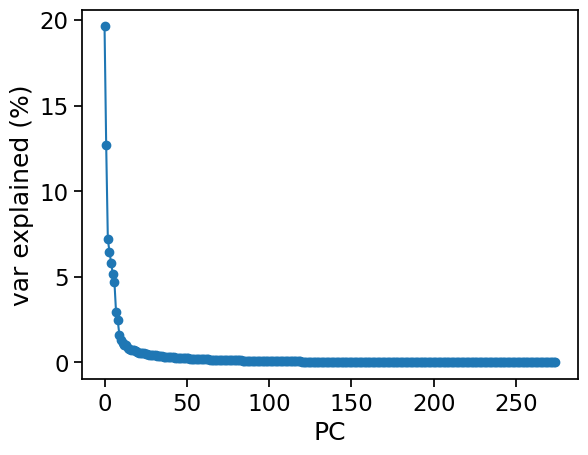

In [275]:
# visualize variance explained by PCs
plt.plot(pca.explained_variance_ratio_*100, 'o-')
plt.xlabel('PC')
plt.ylabel('var explained (%)')

# variance explained by top PCs
latent_dim = 10
latent_space = pca.components_[:latent_dim]
print(pca.explained_variance_ratio_[:latent_dim].sum())

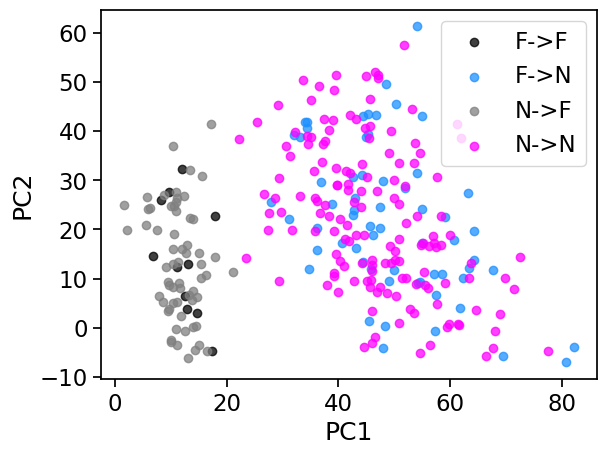

In [276]:
# project responses to each condition onto top PCs
ff_counts_proj = pca.transform(ff_counts.T) # input should be samples x features
fn_counts_proj = pca.transform(fn_counts.T)
nf_counts_proj = pca.transform(nf_counts.T)
nn_counts_proj = pca.transform(nn_counts.T)

a = .75
pc_idx_x = 0
pc_idx_y = 1
plt.scatter(ff_counts_proj[:,pc_idx_x], ff_counts_proj[:,pc_idx_y], c='black', alpha=a, label='F->F')
plt.scatter(fn_counts_proj[:,pc_idx_x], fn_counts_proj[:,pc_idx_y], c='dodgerblue', alpha=a, label='F->N')
plt.scatter(nf_counts_proj[:,pc_idx_x], nf_counts_proj[:,pc_idx_y], c='gray', alpha=a, label='N->F')
plt.scatter(nn_counts_proj[:,pc_idx_x], nn_counts_proj[:,pc_idx_y], c='fuchsia', alpha=a, label='N->N')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend();

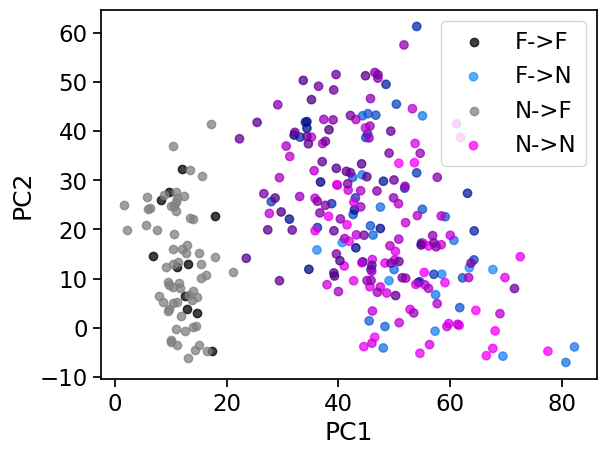

In [277]:
# project responses to each condition onto top PCs
a = .75
pc_idx_x = 0
pc_idx_y = 1

fn_norm = plt.Normalize(0,len(fn_counts_proj))
fn_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["dodgerblue","navy"])
nn_norm = plt.Normalize(0,len(nn_counts_proj))
nn_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["fuchsia","indigo"])

plt.scatter(ff_counts_proj[:,pc_idx_x], ff_counts_proj[:,pc_idx_y], c='black', alpha=a, label='F->F')
plt.scatter(fn_counts_proj[:,pc_idx_x], fn_counts_proj[:,pc_idx_y], c=range(len(fn_counts_proj)), cmap=fn_cmap, norm=fn_norm, alpha=a, label='F->N')
plt.scatter(nf_counts_proj[:,pc_idx_x], nf_counts_proj[:,pc_idx_y], c='gray', alpha=a, label='N->F')
plt.scatter(nn_counts_proj[:,pc_idx_x], nn_counts_proj[:,pc_idx_y], c=range(len(nn_counts_proj)), cmap=nn_cmap, norm=nn_norm, alpha=a, label='N->N')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend();

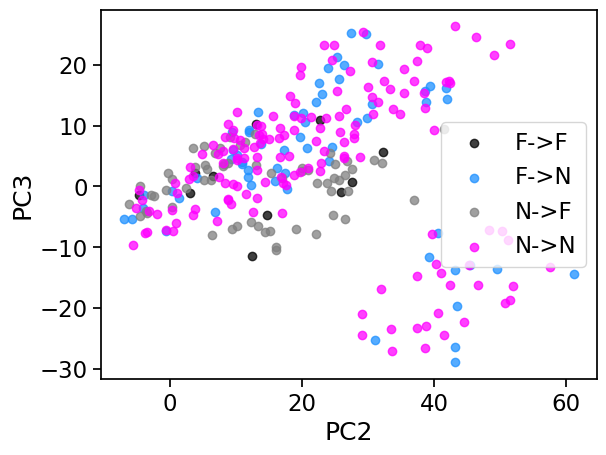

In [278]:
# project responses to each condition onto top PCs
a = .75
pc_idx_x = 1
pc_idx_y = 2
plt.scatter(ff_counts_proj[:,pc_idx_x], ff_counts_proj[:,pc_idx_y], c='black', alpha=a, label='F->F')
plt.scatter(fn_counts_proj[:,pc_idx_x], fn_counts_proj[:,pc_idx_y], c='dodgerblue', alpha=a, label='F->N')
plt.scatter(nf_counts_proj[:,pc_idx_x], nf_counts_proj[:,pc_idx_y], c='gray', alpha=a, label='N->F')
plt.scatter(nn_counts_proj[:,pc_idx_x], nn_counts_proj[:,pc_idx_y], c='fuchsia', alpha=a, label='N->N')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend();

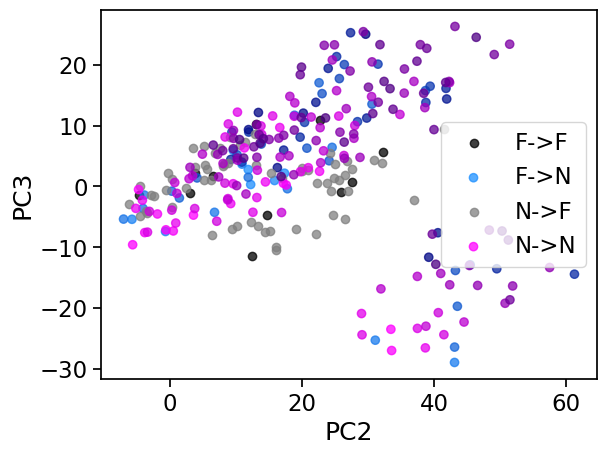

In [279]:
# project responses to each condition onto top PCs
a = .75
pc_idx_x = 1
pc_idx_y = 2

fn_norm = plt.Normalize(0,len(fn_counts_proj))
fn_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["dodgerblue","navy"])
nn_norm = plt.Normalize(0,len(nn_counts_proj))
nn_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["fuchsia","indigo"])

plt.scatter(ff_counts_proj[:,pc_idx_x], ff_counts_proj[:,pc_idx_y], c='black', alpha=a, label='F->F')
plt.scatter(fn_counts_proj[:,pc_idx_x], fn_counts_proj[:,pc_idx_y], c=range(len(fn_counts_proj)), cmap=fn_cmap, norm=fn_norm, alpha=a, label='F->N')
plt.scatter(nf_counts_proj[:,pc_idx_x], nf_counts_proj[:,pc_idx_y], c='gray', alpha=a, label='N->F')
plt.scatter(nn_counts_proj[:,pc_idx_x], nn_counts_proj[:,pc_idx_y], c=range(len(nn_counts_proj)), cmap=nn_cmap, norm=nn_norm, alpha=a, label='N->N')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend();

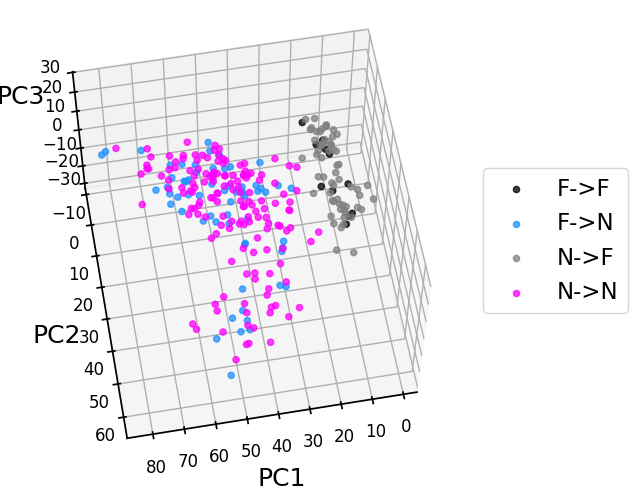

In [280]:
# project responses to each condition onto top PCs - 3d plot
a = .75
lp = 10
sz = 12
pc_idx_x = 0
pc_idx_y = 1
pc_idx_z = 2

ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
ax.tick_params(axis='both', which='major', labelsize=sz)
ax.xaxis.labelpad=lp; ax.yaxis.labelpad=lp; ax.zaxis.labelpad=lp

ax.scatter(ff_counts_proj[:,pc_idx_x], ff_counts_proj[:,pc_idx_y], ff_counts_proj[:,pc_idx_z], c='black', alpha=a, label='F->F', zorder=3)
ax.scatter(fn_counts_proj[:,pc_idx_x], fn_counts_proj[:,pc_idx_y], fn_counts_proj[:,pc_idx_z], c='dodgerblue', alpha=a, label='F->N', zorder=1)
ax.scatter(nf_counts_proj[:,pc_idx_x], nf_counts_proj[:,pc_idx_y], nf_counts_proj[:,pc_idx_z], c='gray', alpha=a, label='N->F', zorder=2)
ax.scatter(nn_counts_proj[:,pc_idx_x], nn_counts_proj[:,pc_idx_y], nn_counts_proj[:,pc_idx_z], c='fuchsia', alpha=a, label='N->N', zorder=0)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.view_init(elev=60, azim=80, roll=0)
# plt.tight_layout();

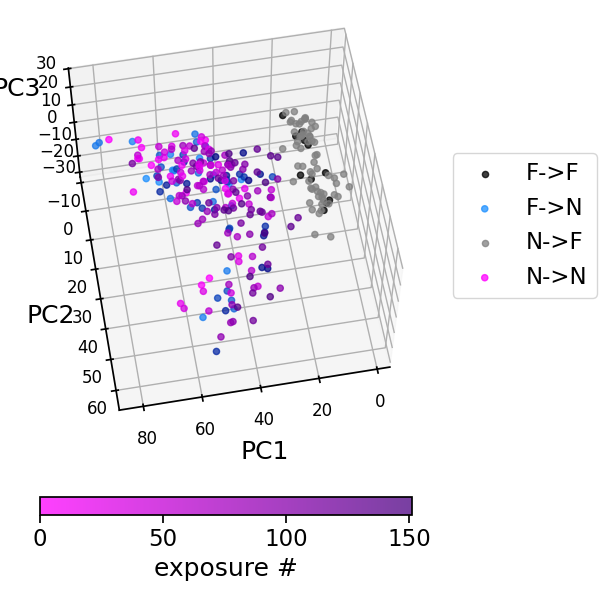

In [281]:
# project responses to each condition onto top PCs - 3d plot, over time
a = .75
lp = 10
sz = 12
s = 6
pc_idx_x = 0
pc_idx_y = 1
pc_idx_z = 2

fn_norm = plt.Normalize(0,len(fn_counts_proj))
fn_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["dodgerblue","navy"])
nn_norm = plt.Normalize(0,len(nn_counts_proj))
nn_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["fuchsia","indigo"])

ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
ax.tick_params(axis='both', which='major', labelsize=sz)
ax.xaxis.labelpad=lp; ax.yaxis.labelpad=lp; ax.zaxis.labelpad=lp

ax.scatter(ff_counts_proj[:,pc_idx_x], ff_counts_proj[:,pc_idx_y], ff_counts_proj[:,pc_idx_z], c='black', alpha=a, label='F->F', zorder=3)
fn_sc = ax.scatter(fn_counts_proj[:,pc_idx_x], fn_counts_proj[:,pc_idx_y], fn_counts_proj[:,pc_idx_z], c=range(len(fn_counts_proj)), cmap=fn_cmap, norm=fn_norm, 
                   alpha=a, label='F->N', zorder=1)
ax.scatter(nf_counts_proj[:,pc_idx_x], nf_counts_proj[:,pc_idx_y], nf_counts_proj[:,pc_idx_z], c='gray', alpha=a, label='N->F', zorder=2)
nn_sc = ax.scatter(nn_counts_proj[:,pc_idx_x], nn_counts_proj[:,pc_idx_y], nn_counts_proj[:,pc_idx_z], c=range(len(nn_counts_proj)), cmap=nn_cmap, norm=nn_norm, 
                   alpha=a, label='N->N', zorder=0)

# first and last trial
# ax.plot(fn_counts_proj[[0,-1],pc_idx_x], fn_counts_proj[[0,-1],pc_idx_y], fn_counts_proj[[0,-1],pc_idx_z], c='navy', zorder=10, markersize=s)
# ax.plot(nn_counts_proj[[0,-1],pc_idx_x], nn_counts_proj[[0,-1],pc_idx_y], nn_counts_proj[[0,-1],pc_idx_z], c='indigo', zorder=10, markersize=s)

# plt.colorbar(fn_sc, orientation='horizontal', shrink=.6, anchor=(0.5, 1.5), label='exposure #')
plt.colorbar(nn_sc, orientation='horizontal', shrink=.6, anchor=(0.5, 1.5), label='exposure #')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.view_init(elev=60, azim=80, roll=0)
# plt.tight_layout();

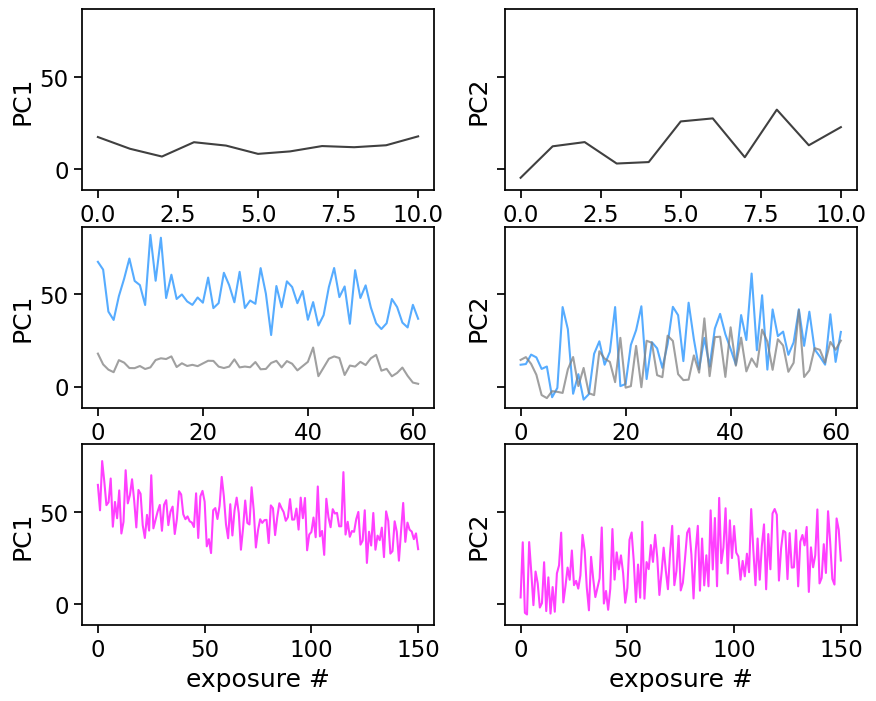

In [282]:
# plot projection onto top PCs vs. exposure #
fig, ax = plt.subplots(3,2, figsize=(10,8), sharey=True)
a = .75
pc_idx_x = 0
pc_idx_y = 1

ax[0,0].plot(ff_counts_proj[:,pc_idx_x], c='black', alpha=a, label='F->F')
ax[1,0].plot(fn_counts_proj[:,pc_idx_x], c='dodgerblue', alpha=a, label='F->N')
ax[1,0].plot(nf_counts_proj[:,pc_idx_x], c='gray', alpha=a, label='N->F')
ax[2,0].plot(nn_counts_proj[:,pc_idx_x], c='fuchsia', alpha=a, label='N->N')
ax[2,0].set_xlabel('exposure #')
for i in range(3):
    ax[i,0].set_ylabel('PC1')

ax[0,1].plot(ff_counts_proj[:,pc_idx_y], c='black', alpha=a, label='F->F')
ax[1,1].plot(fn_counts_proj[:,pc_idx_y], c='dodgerblue', alpha=a, label='F->N')
ax[1,1].plot(nf_counts_proj[:,pc_idx_y], c='gray', alpha=a, label='N->F')
ax[2,1].plot(nn_counts_proj[:,pc_idx_y], c='fuchsia', alpha=a, label='N->N')
ax[2,1].set_xlabel('exposure #')
for i in range(3):
    ax[i,1].set_ylabel('PC2')

# plt.legend();

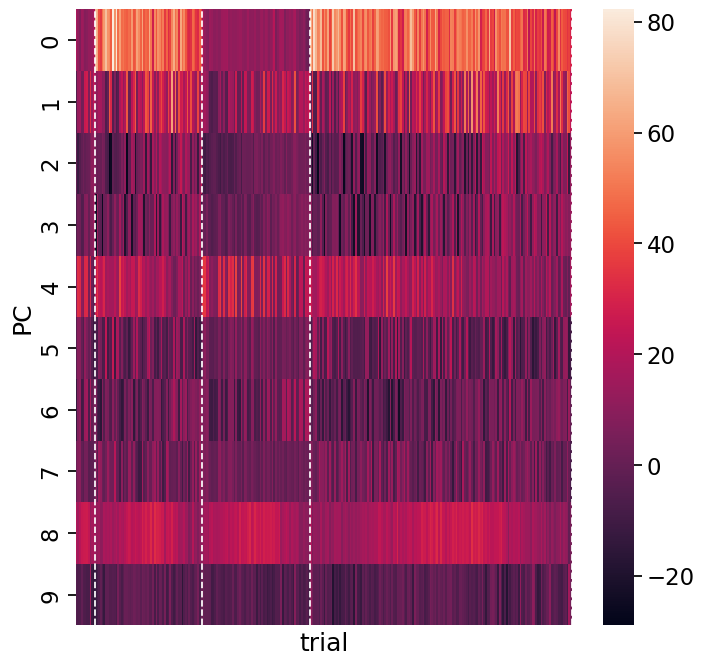

In [283]:
# heatmap of projection onto PCs vs. time (components x concatenated times)
plt.figure(figsize=(8,8))
pcs = pca.components_
sns.heatmap((pcs @ concat_counts)[:10,:])
plt.xticks([])
plt.xlabel('trial')
plt.ylabel('PC')

# add lines to separate conditions
cum_ntr = 0
for ntr in [len(ff_idx), len(fn_idx), len(nf_idx), len(nn_idx)]:
    cum_ntr += ntr
    plt.axvline(x=cum_ntr, color='w', linestyle='--', linewidth=1.25)    
    
# label conditions
# ff_responses,fn_responses,nf_responses,nn_responses

## Clustering - time x unit

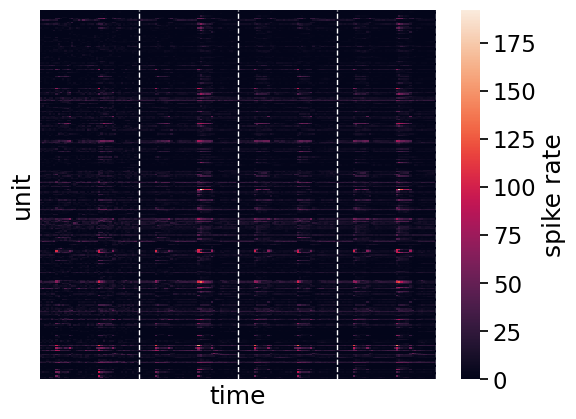

In [284]:
sns.heatmap(concat_responses, cbar_kws={'label':'spike rate'})
plt.xticks([])
plt.yticks([])
plt.xlabel('time')
plt.ylabel('unit')

# add lines to separate conditions
for i in range(1,5):
    plt.axvline(x=i*len(time_bins), color='w', linestyle='--', linewidth=1)

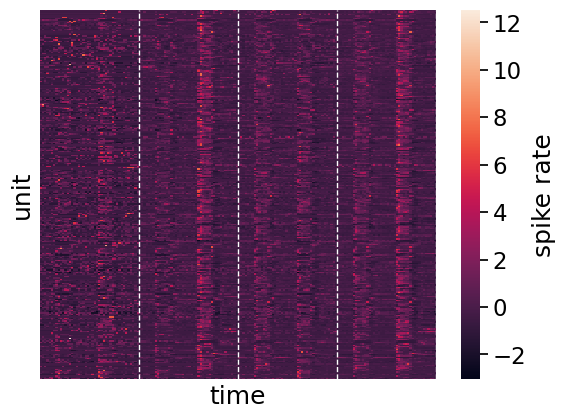

In [285]:
concat_responses_zscore = stats.zscore(concat_responses,axis=1)

sns.heatmap(concat_responses_zscore, cbar_kws={'label':'spike rate'})
plt.xticks([])
plt.yticks([])
plt.xlabel('time')
plt.ylabel('unit')

# add lines to separate conditions
for i in range(1,5):
    plt.axvline(x=i*len(time_bins), color='w', linestyle='--', linewidth=1)

## Clustering - trial x unit

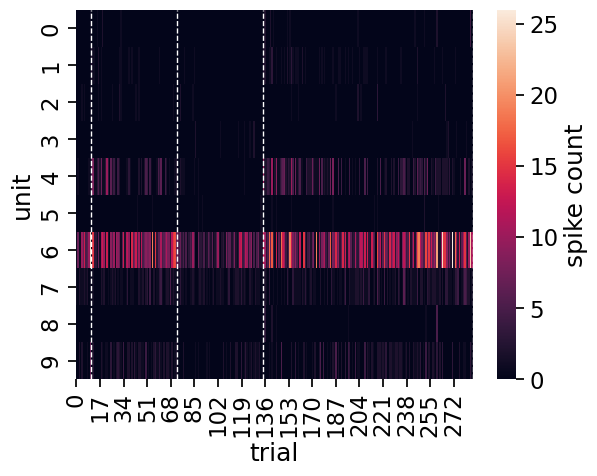

In [286]:
sns.heatmap(concat_counts[:10,:], cbar_kws={'label':'spike count'})
# plt.xticks([])
# plt.yticks([])
plt.xlabel('trial')
plt.ylabel('unit')

# add lines to separate conditions
cum_ntr = 0
for ntr in [len(ff_idx), len(fn_idx), len(nf_idx), len(nn_idx)]:
    cum_ntr += ntr
    plt.axvline(x=cum_ntr, color='w', linestyle='--', linewidth=1)

# since spike counts are discrete, deman then normalize by the max?, don't zscore basically

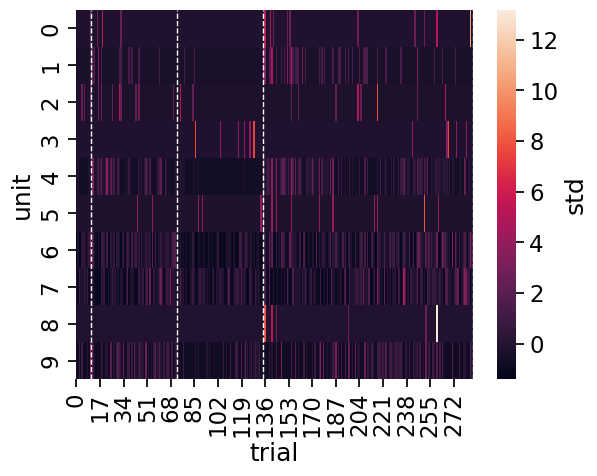

In [287]:
concat_counts_zscore = stats.zscore(concat_counts,axis=1)

sns.heatmap(concat_counts_zscore[:10,:], cbar_kws={'label':'std'})
# plt.xticks([])
# plt.yticks([])
plt.xlabel('trial')
plt.ylabel('unit')

# add lines to separate conditions
cum_ntr = 0
for ntr in [len(ff_idx), len(fn_idx), len(nf_idx), len(nn_idx)]:
    cum_ntr += ntr
    plt.axvline(x=cum_ntr, color='w', linestyle='--', linewidth=1)

## DS analysis - latent space

## DS analysis - full state space

In [288]:
# alternative to PCA on neural data (which is noisy)
# calc euclidean distance in full neural space between when novel stim first comes on, to first timepoint after, to second timepoint after 
# another metric: angle between vectors in full neural space
# distance from each timestep to the first one
# also try average in time windows instead of single timesteps
# can also look at angle between timestamps
# color by novel vs familiar
# check Remington, Jazyeri 2018 for an example of this type of DS analysis